In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [3]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [4]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [5]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [6]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+61.g5843eaa07.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.69 GB available memory.


In [64]:
eq = get("W7-X")
eq.axis = eq.surface.get_axis()
eq.set_initial_guess(ensure_nested=False)

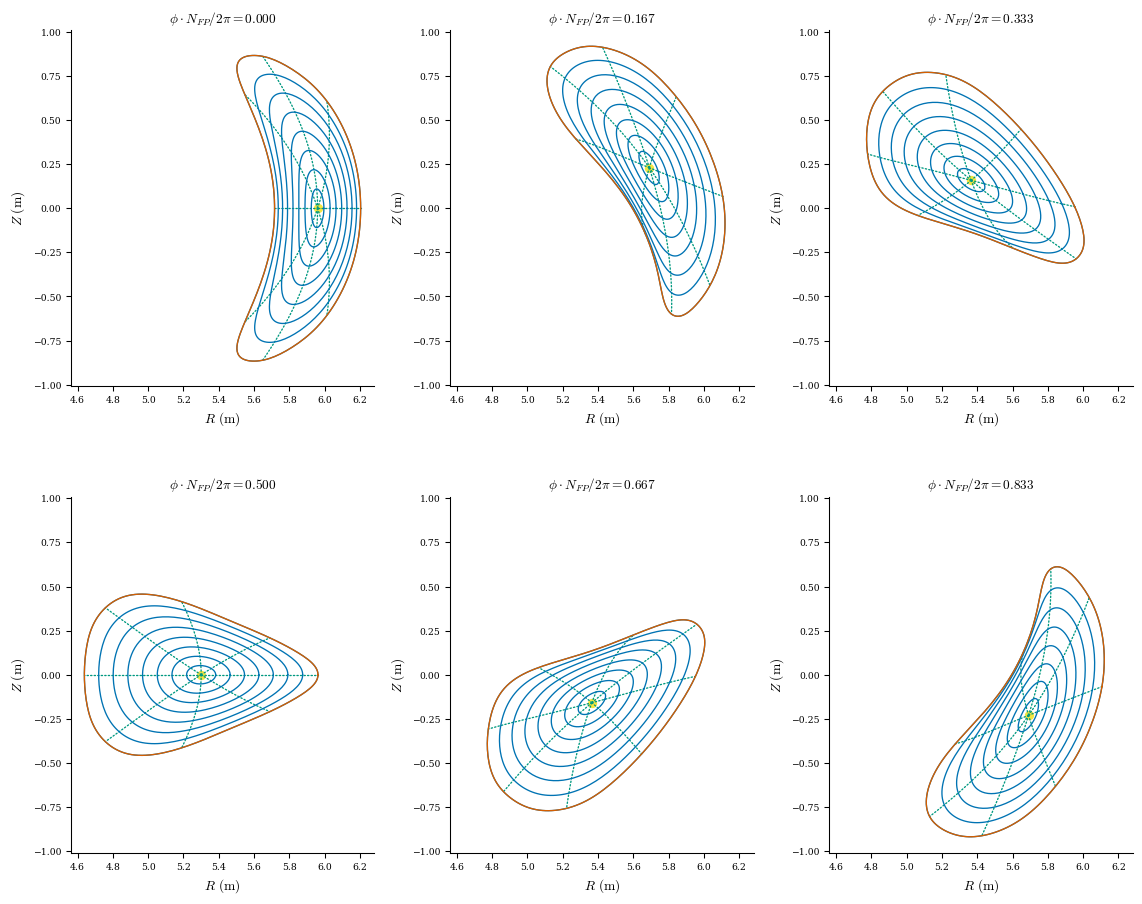

In [65]:
plot_surfaces(eq);

In [73]:
eq, out = eq.solve(maxiter=100, verbose=3, ftol=1e-4, xtol=0, gtol=0);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 78.6 ms
Timer: Objective build = 431 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 246 ms
Timer: LinearConstraintProjection build = 862 ms
Number of parameters: 2784
Number of objectives: 5346
Timer: Initializing the optimization = 1.71 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial Trust Rad

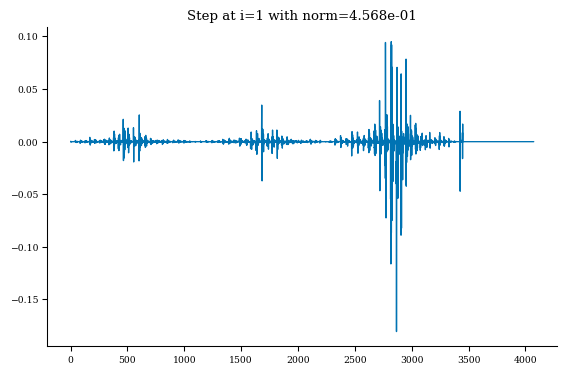

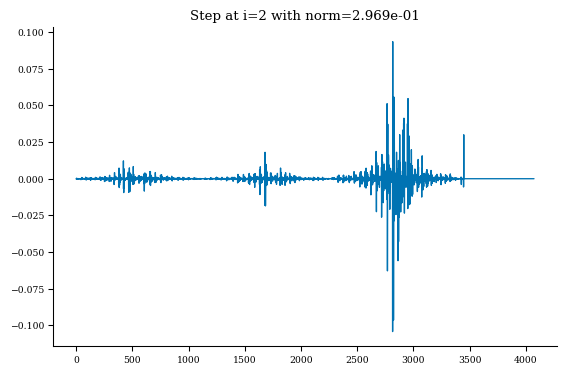

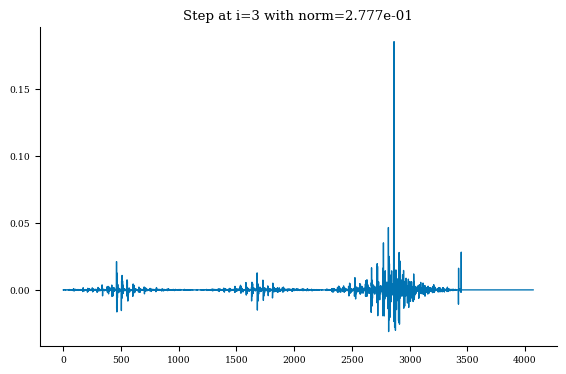

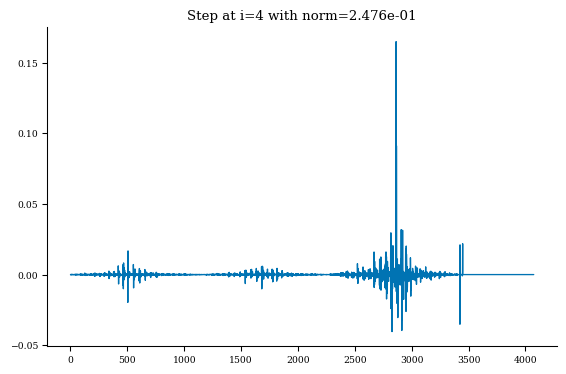

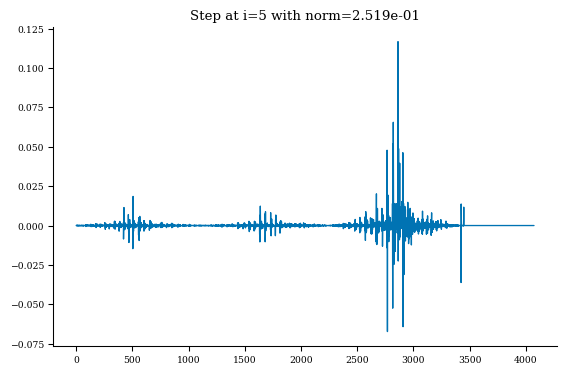

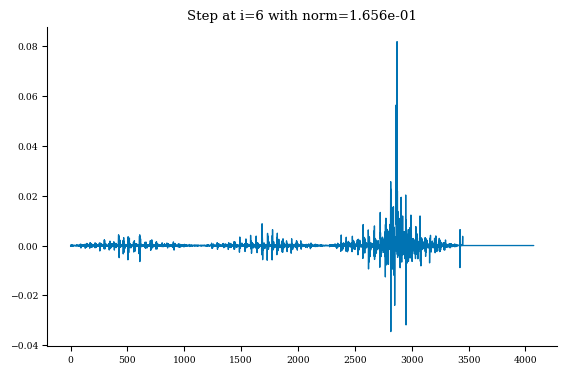

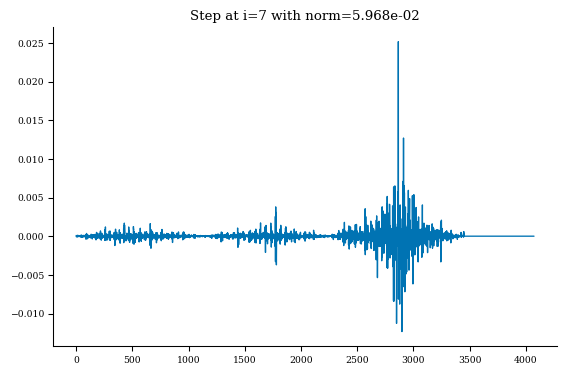

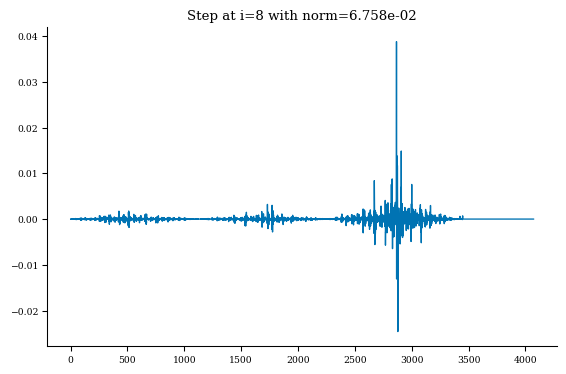

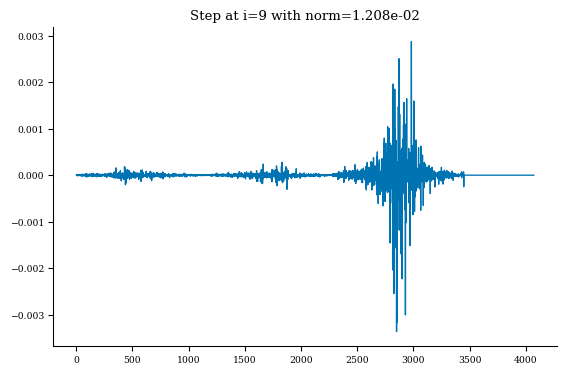

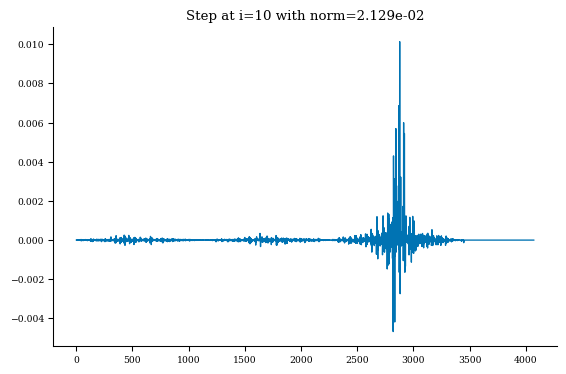

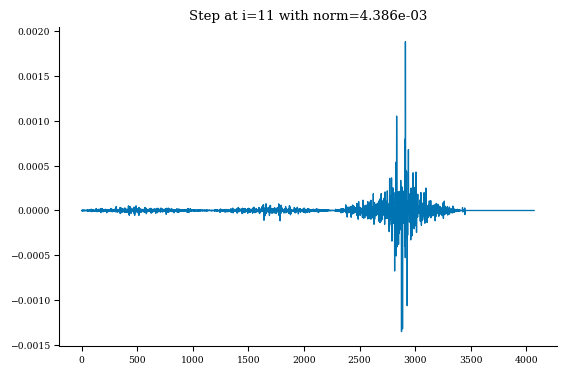

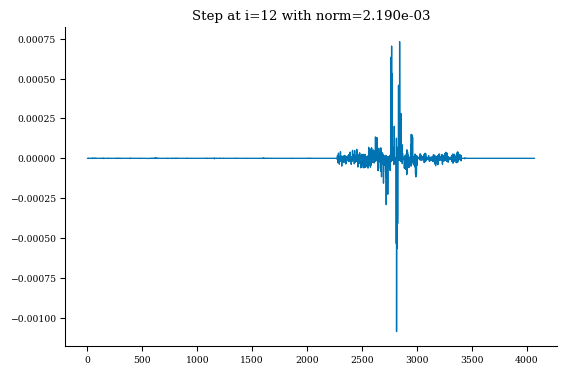

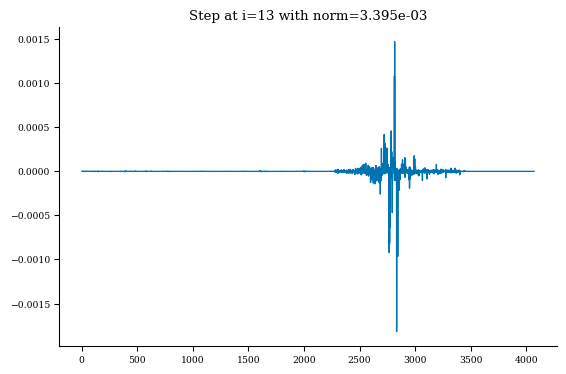

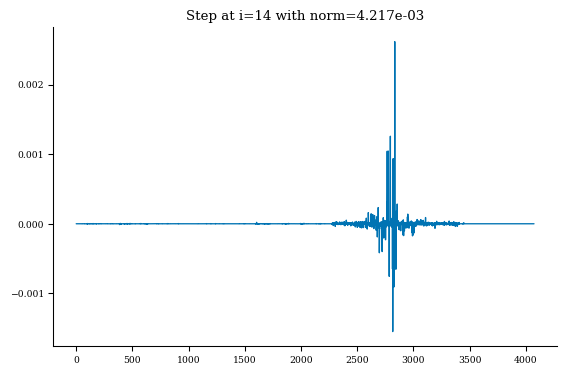

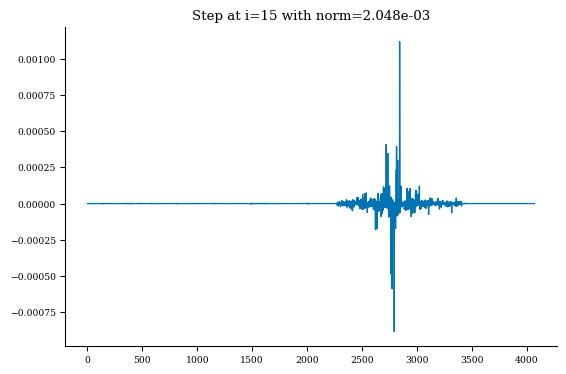

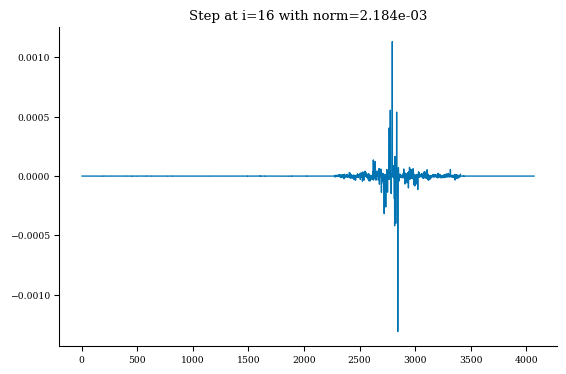

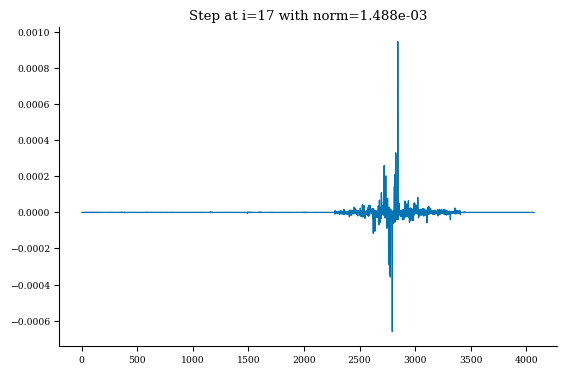

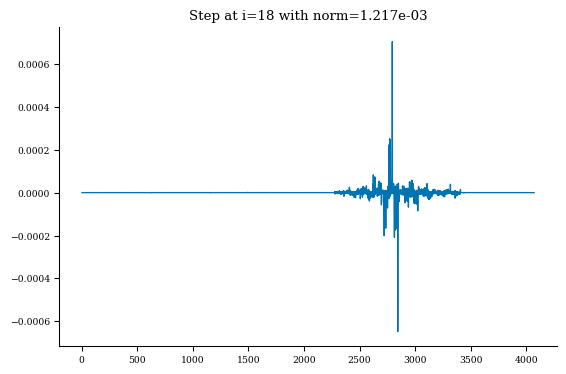

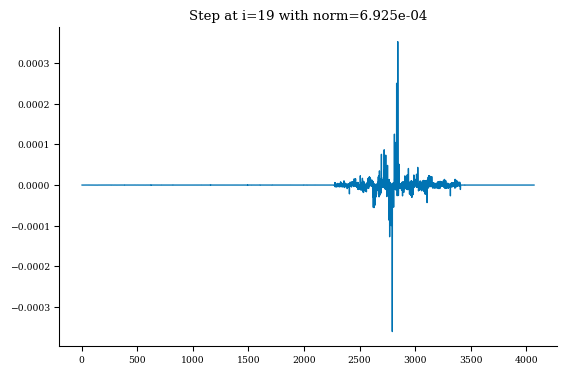

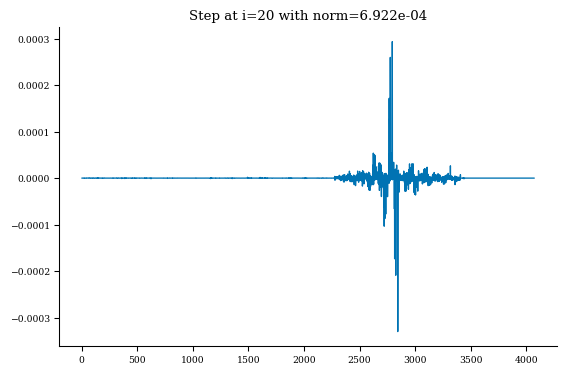

In [68]:
c1 = out["allx"][0]
for i in range(1, 21):
    c2 = out["allx"][i]
    plt.figure()
    step = c2 - c1
    plt.plot(step)
    plt.title(f"Step at i={i} with norm={jnp.linalg.norm(step):.3e}")
    c1 = c2

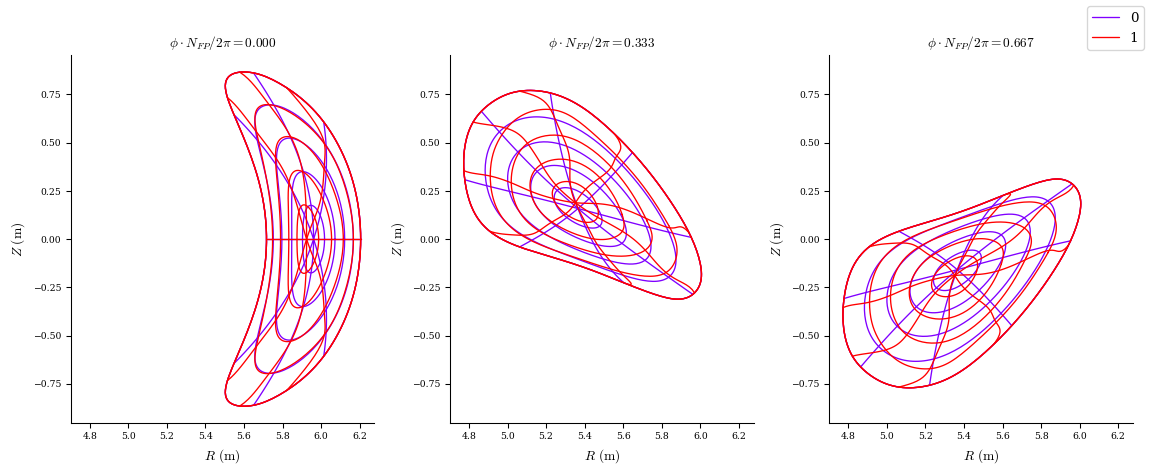

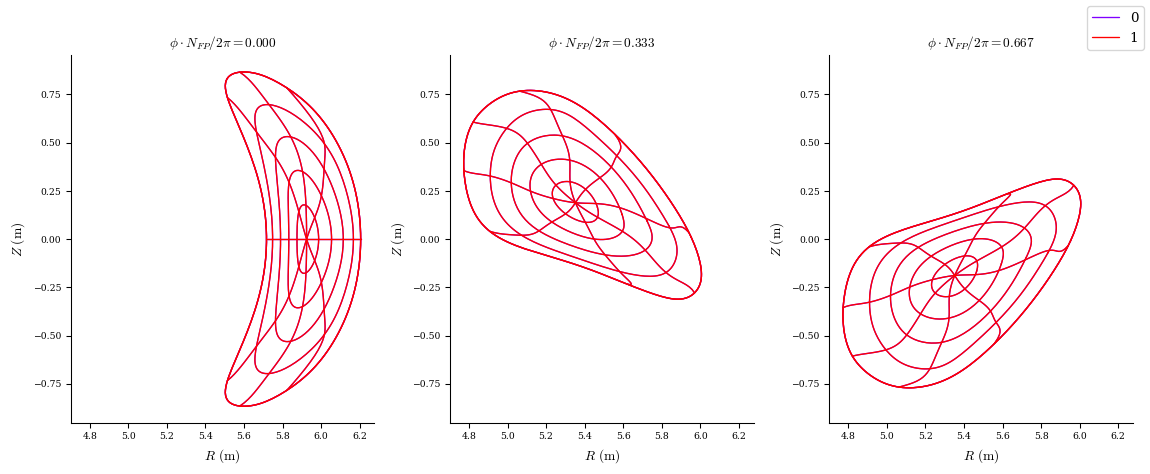

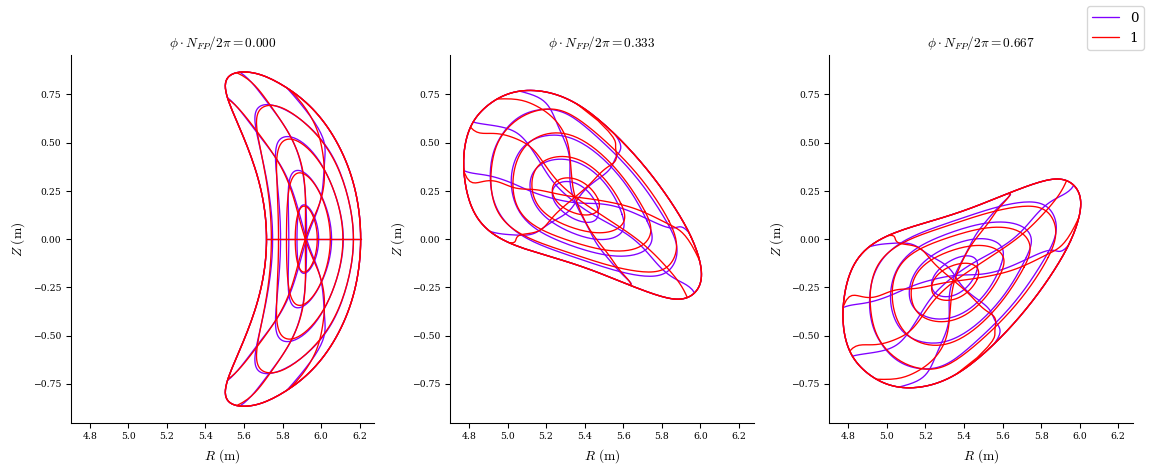

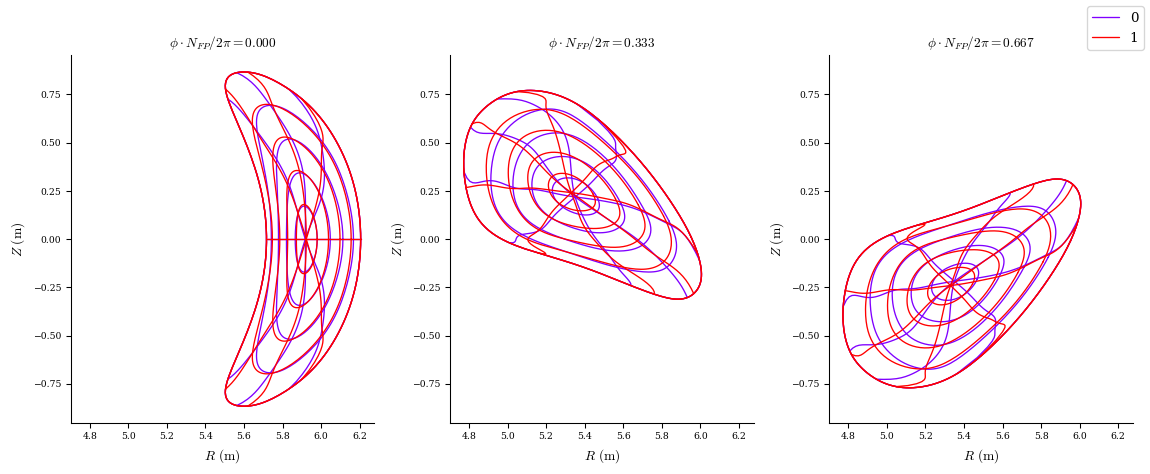

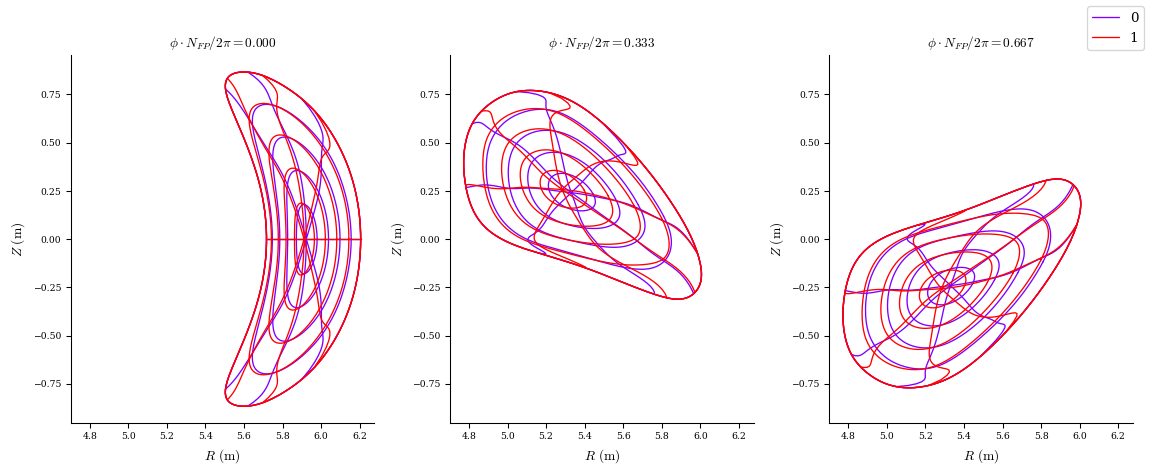

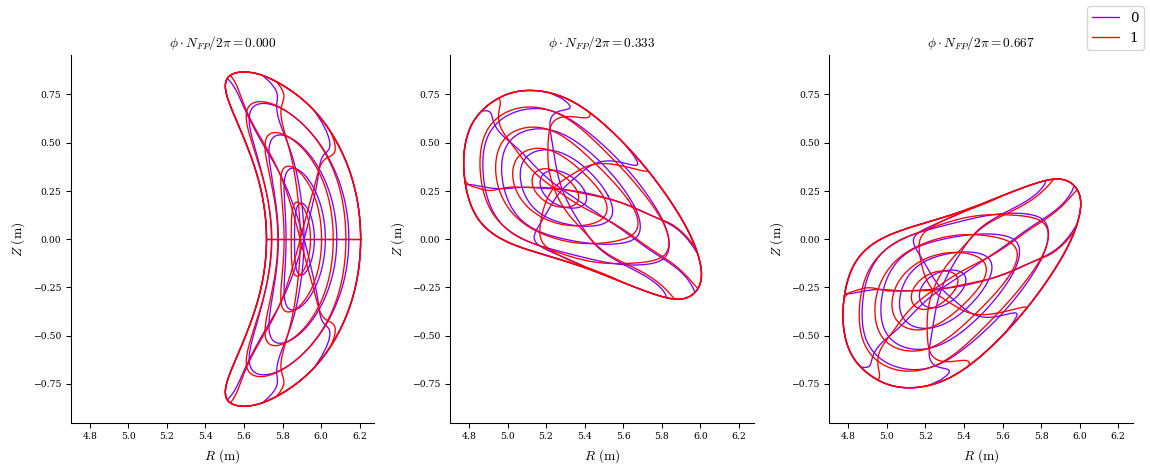

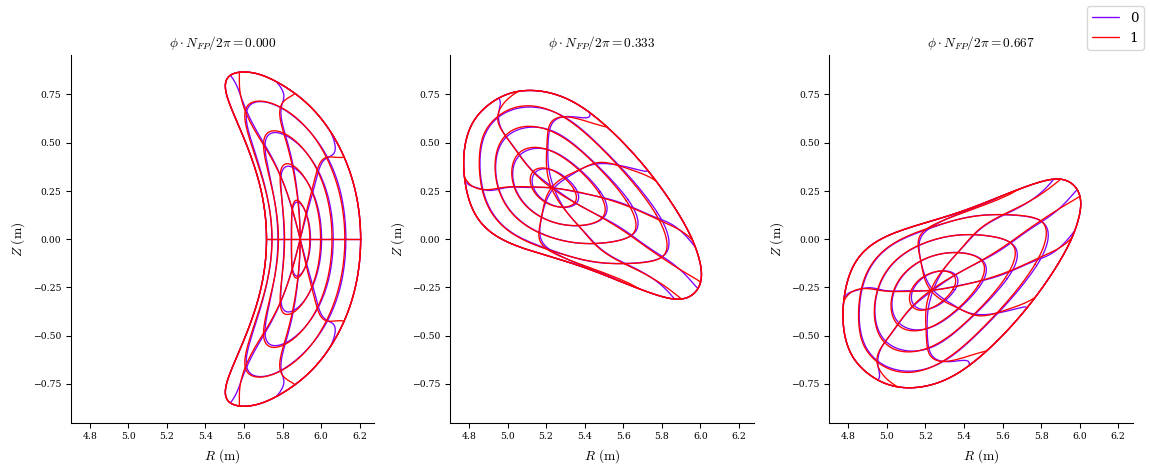

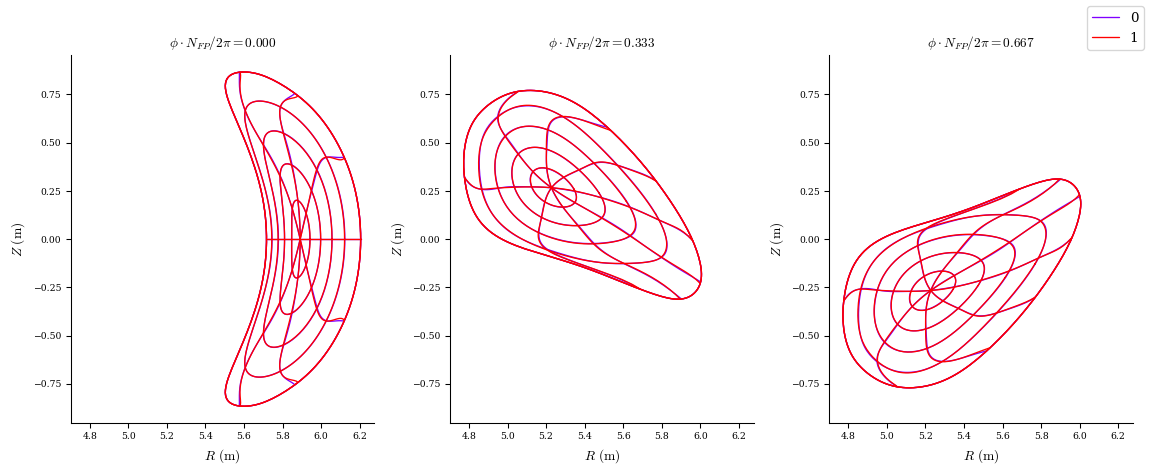

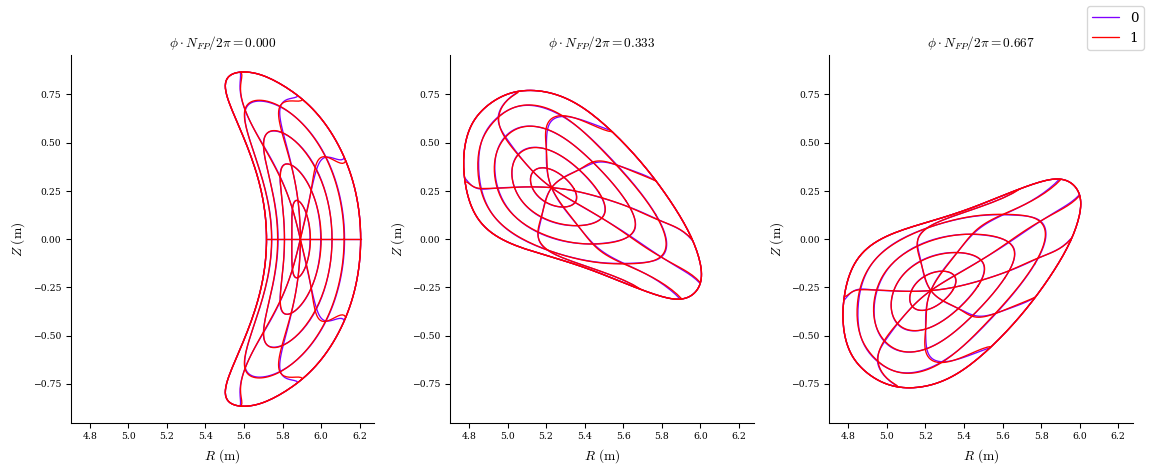

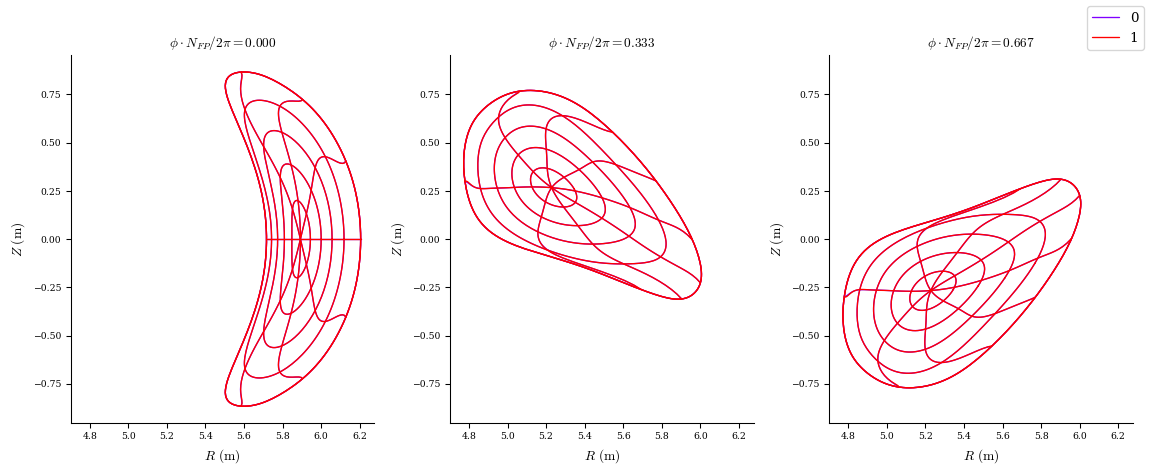

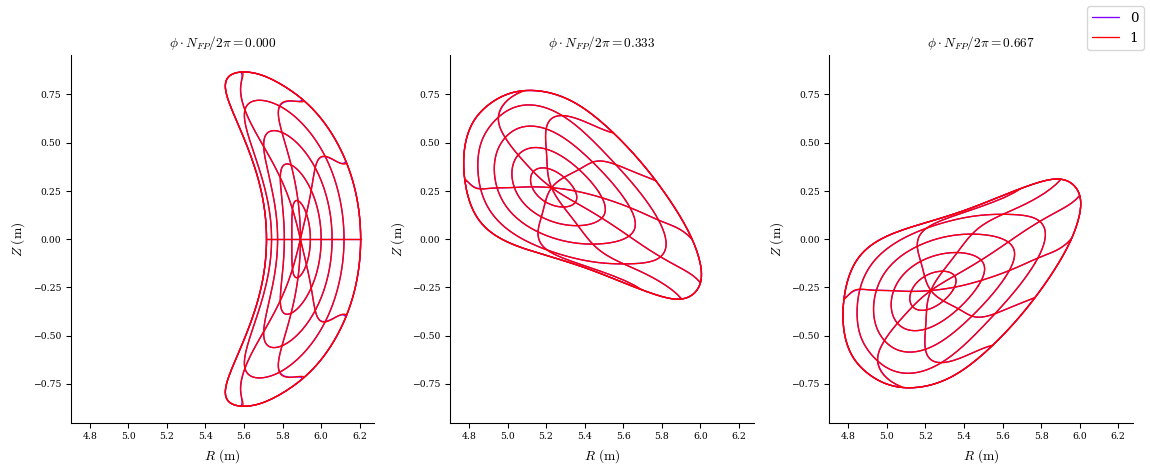

In [62]:
eq_dummy1 = eq.copy()
eq_dummy2 = eq.copy()

c1 = out["history"][0][0]
c2 = out["history"][1][0]

eq_dummy1.params_dict = c1
eq_dummy2.params_dict = c2
for i in range(1, 12):
    plot_comparison([eq_dummy1, eq_dummy2], phi=3, rho=5)
    c1 = c2
    c2 = out["history"][i][0]

    eq_dummy1.params_dict = c1
    eq_dummy2.params_dict = c2

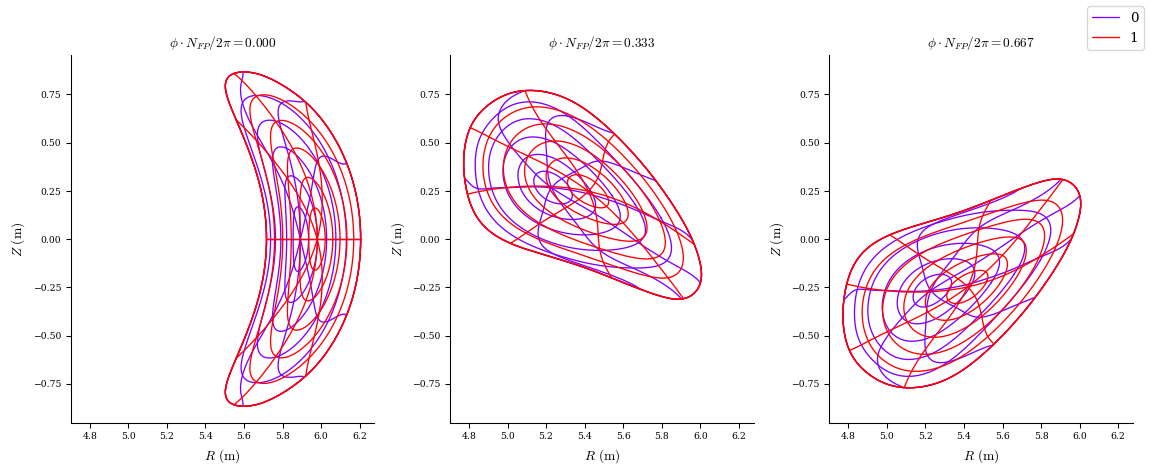

In [76]:
eq0 = get("W7-X")
fig, ax = plot_comparison([eq, eq0], phi=3, rho=6);

In [77]:
eq_dummy1 = eq.copy()
c1 = out["history"][0][0]
eq_dummy1.params_dict = c1
for i in range(26, 95):
    c1 = out["history"][i-26][0]
    eq_dummy1.params_dict = c1
    fig, ax = plot_surfaces(eq_dummy1, phi=3, rho=6)
    fig.suptitle(f"Iteration {i}")
    plt.savefig(f"w7x_solve_iter{i}.png", dpi=500)
    plt.close()

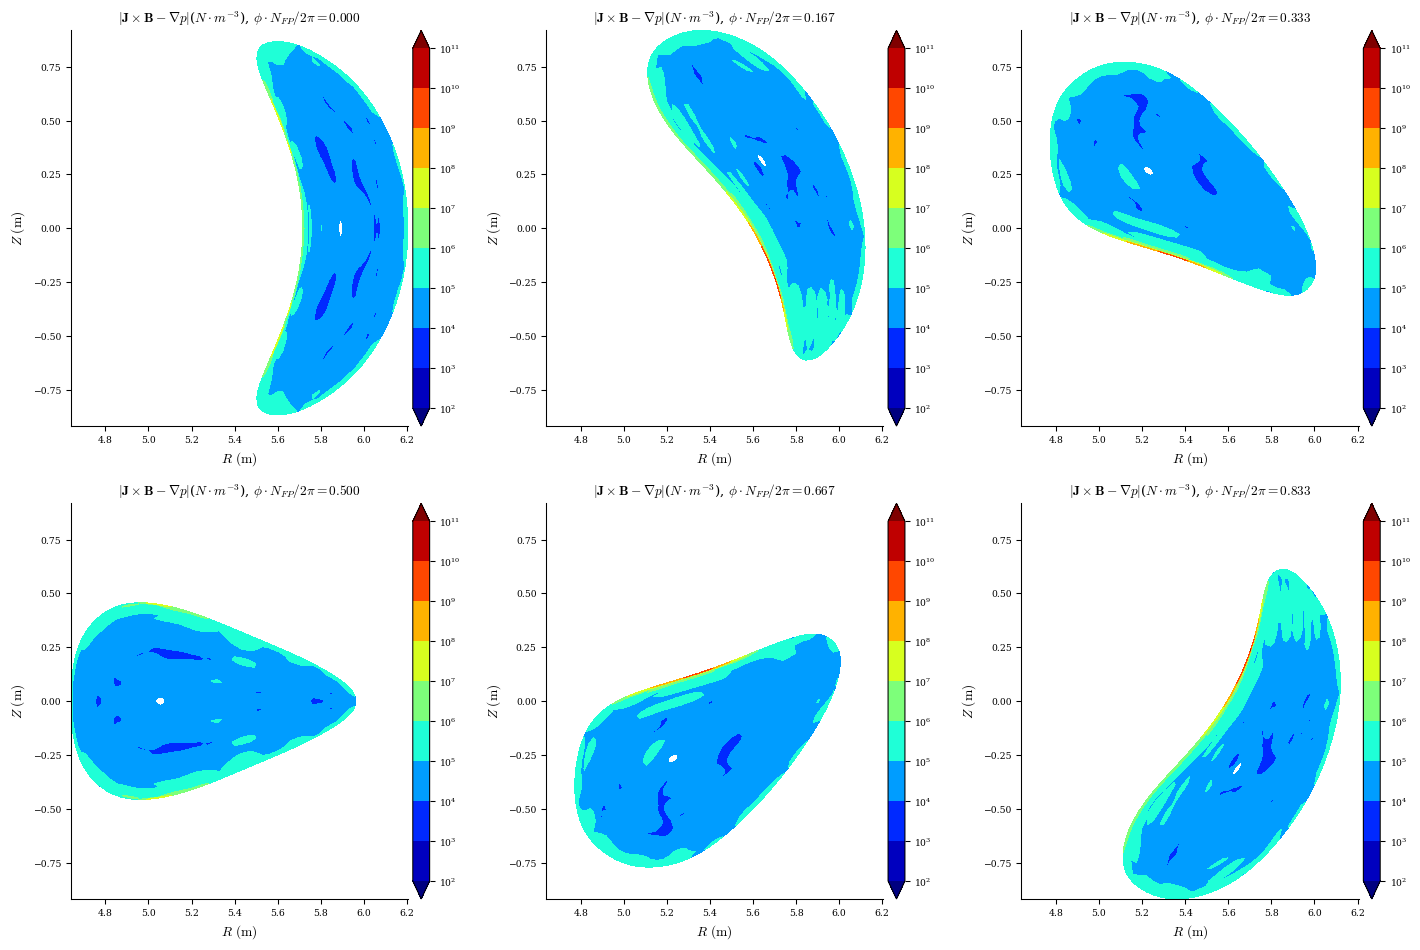

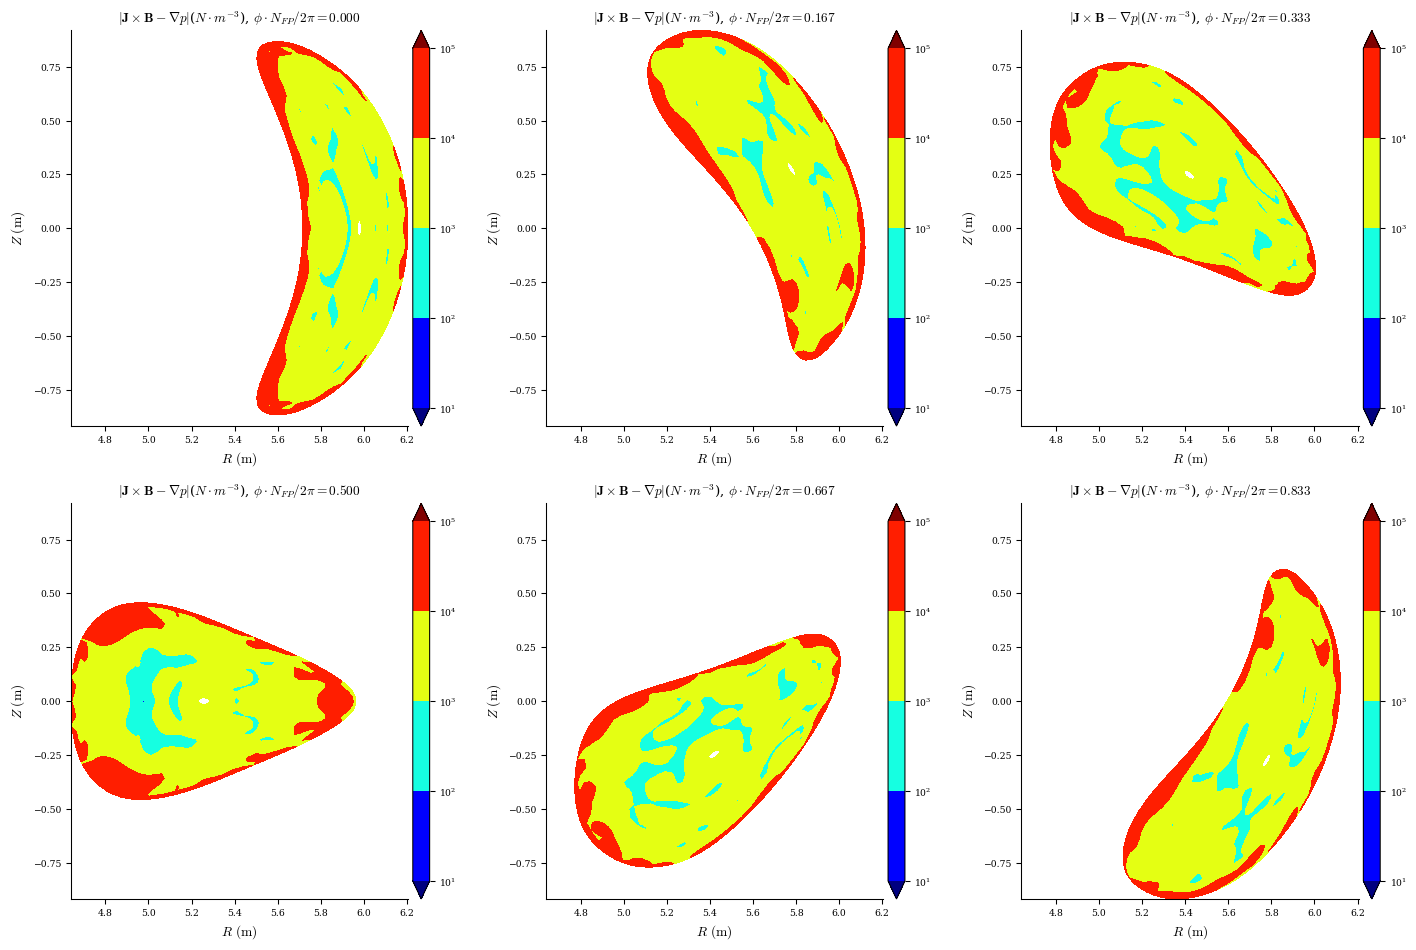

In [75]:
plot_section(eq, "|F|", log=True)
plot_section(eq0, "|F|", log=True);

In [112]:
eq = get("HELIOTRON")
eq.axis = eq.surface.get_axis()
eq.set_initial_guess(ensure_nested=False)
cons = get_fixed_boundary_constraints(eq)
cons = maybe_add_self_consistency(eq, cons)
con = ObjectiveFunction(cons)
obj = ObjectiveFunction(ForceBalance(eq))
lcp = LinearConstraintProjection(obj, con)
lcp.build()
J = obj.jvp_scaled_error(lcp._feasible_tangents.T, obj.x(eq), obj.constants).T
uf, sf, vtf = jnp.linalg.svd(J, full_matrices=True)
smallest_v_dir = put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ vtf[-1, :])
biggest_v_dir = put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ vtf[0, :])

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency


Text(0.5, 1.0, 'Singular Values')

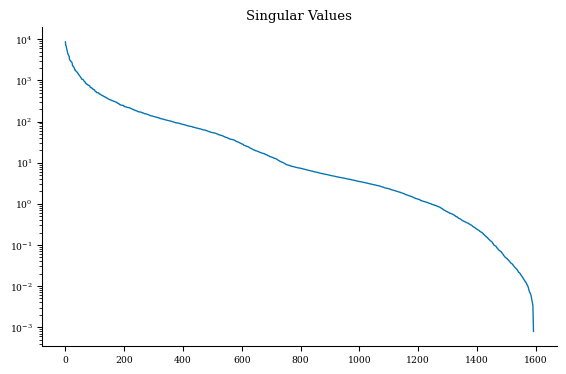

In [113]:
plt.semilogy(sf)
plt.title("Singular Values")

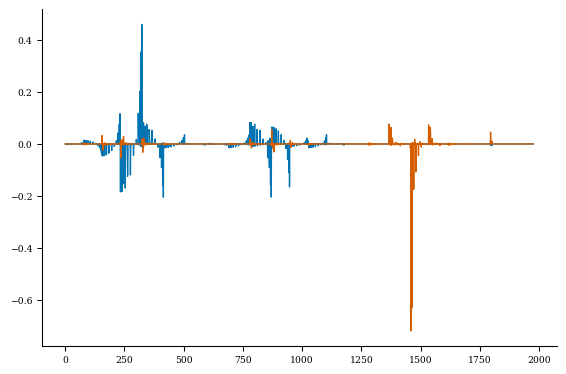

In [114]:
plt.plot(biggest_v_dir)
plt.plot(smallest_v_dir)

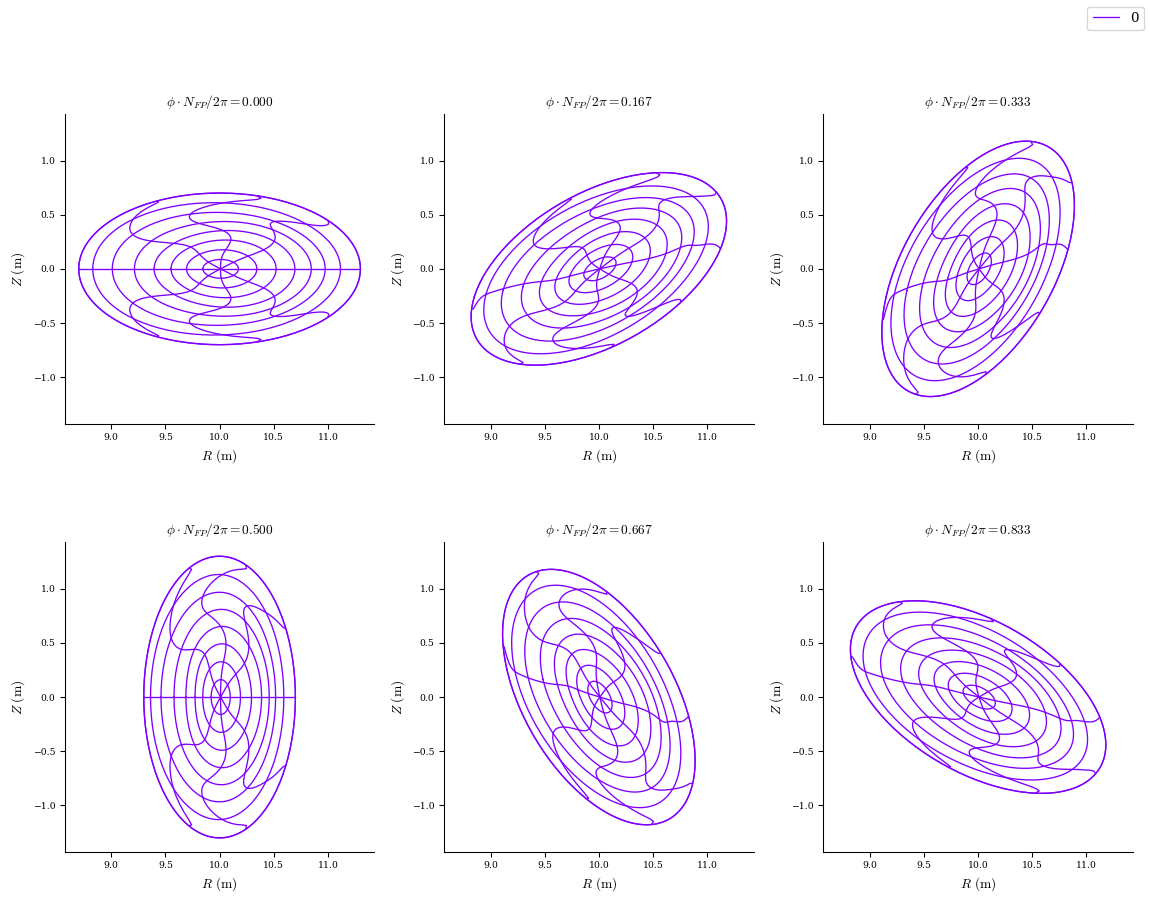

In [128]:
x = eq.pack_params(eq.params_dict)
some_dx = put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ vtf[-1, :])
some_dx2 = put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ vtf[-3, :])
eq_dummy = eq.copy()
xnew = x + (some_dx + some_dx2) * 0.4
params = eq.unpack_params(xnew)
eq_dummy.params_dict = params
plot_comparison([eq_dummy]);

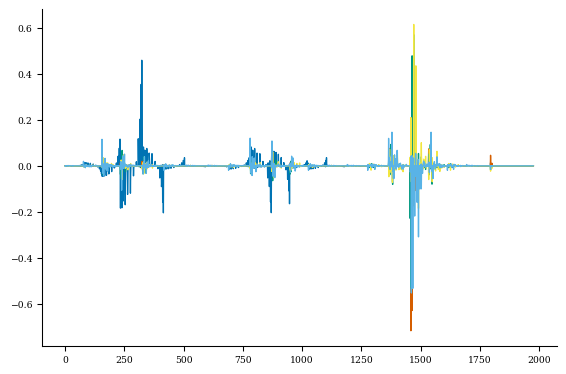

In [129]:
for i in range(5):
    plt.plot(put(jnp.zeros(eq.dim_x), lcp._unfixed_idx, lcp._Z @ vtf[-i, :]))